In [98]:
"""
Chapter 2. 자연어와 단어의 분산 표현
"""

'\nChapter 2. 자연어와 단어의 분산 표현\n'

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from common import util
import ptb

In [2]:
# 2.3.1 파이썬으로 말뭉치 전처리하기
text = 'You say goodbye and I say hello.'

# 단어 단위로 분할
text = text.lower()
text = text.replace('.', ' .')
print(text)

you say goodbye and i say hello .


In [3]:
# 공백을 기준으로 분할
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
# 단어에 ID부여
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [6]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [7]:
id_to_word[1]

'say'

In [8]:
word_to_id['hello']

5

In [9]:
# words -> corpus로 변경
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [10]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [11]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text) 

In [12]:
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [18]:
# 2.3.4 동시발생 행렬
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [19]:
co_matrix = create_co_matrix(corpus, len(word_to_id))
co_matrix

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [20]:
# 2.3.5 벡터 간 유사도
def cos_similarity(x, y, eps = 1e-8): # 인수로 제로벡터가 들어오면 오류 발생, 이를 막기 위해 분모에 작은 값을 더해줌
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [21]:
c0 = co_matrix[word_to_id['you']]
c1 = co_matrix[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


In [22]:
# 2.3.6 유사 단어의 랭킹 표시
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 검색어 찾기
    if query not in word_to_id:
        print('%s를(을) 찾을 수 없습니다.' % query)
        return
    
    print('\n[query] ' +  query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 유사도 계산
    vocab_size = len(word_to_id)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 유사도 기준으로 내림차순으로 출력
    count = 0
    
    """
    argsort(): numpy 배열의 원소를 오름차순으로 정렬 후 인덱스 배열을 리턴, -1을 곱하면 내림차순으로 정렬
    """
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query: # 검색어인 경우 pass
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [23]:
most_similar('you', word_to_id, id_to_word, co_matrix)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [26]:
# 2.4.1 상호정보량
def ppmi(C, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

    return M

In [27]:
W = ppmi(co_matrix) # common/utils.py에 ppmi() 함수 구현

In [28]:
np.set_printoptions(precision=3)
print('동시발생행렬')
print(co_matrix)
print('-' * 50)
print('PPMI')
print(W)

동시발생행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [29]:
# 2.4.3 SVD에 의한 차원 감소
U, S, V = np.linalg.svd(W) # numpy의 linalg 모듈이 제공하는 svd 메서드 사용

In [30]:
print(co_matrix[0]) # 동시발생 행렬
print(W[0]) # PPMI 행렬
print(U[0]) # SVD
print(U[0, :2]) # U의 차원 감소(예를 들어 2차원 벡터로 줄이는 경우)

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01  0.000e+00  9.323e-01
  2.226e-16]
[-3.409e-01 -1.110e-16]


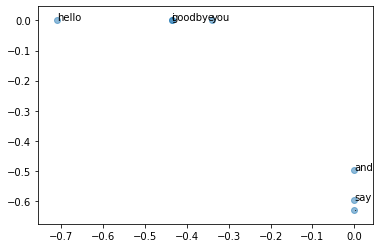

In [31]:
# 2벡터를 그래프로 표현
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:, 1], alpha = 0.5)
plt.show()

In [32]:
# 2.4.4 PTB 데이터셋

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [33]:
# 2.4.5 PTB 데이터셋 평가

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산...')
W = ppmi(C)

print('SVD 계산...')
try:
    # truncated SVD(fast)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    # SVD(slow)
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size] # 모든 열에서 wordvec_size번째까지 원소 꺼내기

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산...
PPMI 계산...
SVD 계산...

[query] you
 i: 0.7159414887428284
 we: 0.6225911378860474
 do: 0.5794521570205688
 always: 0.5220422744750977
 anybody: 0.5198028683662415

[query] year
 month: 0.6702927350997925
 quarter: 0.664528489112854
 last: 0.6270698308944702
 earlier: 0.6008700132369995
 next: 0.5660039186477661

[query] car
 auto: 0.6248607635498047
 luxury: 0.619133710861206
 cars: 0.5737773180007935
 truck: 0.5510666370391846
 vehicle: 0.5355417132377625

[query] toyota
 motor: 0.7090374231338501
 motors: 0.6315178275108337
 nissan: 0.6233994960784912
 lexus: 0.6056314706802368
 mazda: 0.6045007109642029
